In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-07 11:56:48.743539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 11:56:50.193481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 7600
end_idx = 7660
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(60, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(60, 96, 7)
(40320,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(60, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(60, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv}, compile=False)

2023-08-07 11:56:59.500844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    
    # test_ws_y
    test_ws_y_target = test_ws_y[start_idx:end_idx]
    ws_penalty_sum1 = 0
    for i in range(duration):
        for j in range(96):
            penalty_ws1 = np.abs(yhat[i, j] - test_ws_y_target[i, j])**2
            
            ws_penalty_sum1 += penalty_ws1
    
    # ================ gate penalty + ws penalty ================
    #penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*(ws_penalty_sum + ws_penalty_sum1)  # good
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-07 11:57:02.005841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step
CPU time: 6619.391724776942 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

2/2 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.60248391 0.69031446 0.78306109 ... 0.40580561 0.94233841 0.29328761]
Fitness value of the best solution = 0.0001534970834600318


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

2/2 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

619


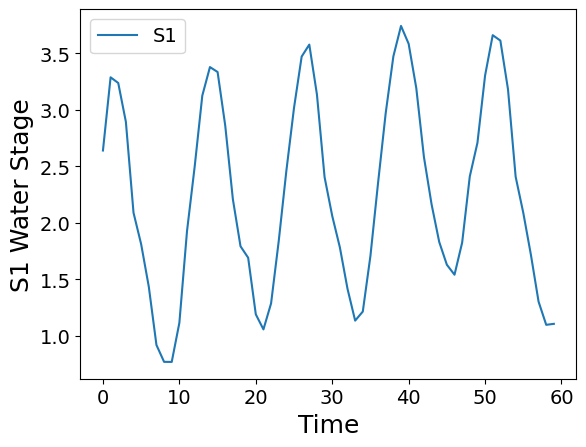

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event1.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.602484,0.690314,0.783061,0.146193,0.460013,0.279520,0.085605,0.200479,0.738981,0.465460,...,0.035142,0.028377,0.962016,0.581506,0.446763,0.580243,0.724715,0.499600,0.635529,0.832469
1,0.705194,0.779069,0.368858,0.971015,0.976793,0.389939,0.502269,0.095038,0.443957,0.952173,...,0.867034,0.619793,0.935135,0.711805,0.921480,0.932510,0.540710,0.609698,0.722634,0.175887
2,0.669689,0.219560,0.473805,0.398027,0.585342,0.056677,0.003067,0.342284,0.219035,0.816743,...,0.527966,0.208431,0.131664,0.868719,0.579754,0.446018,0.237932,0.157805,0.836754,0.053994
3,0.950935,0.604765,0.207285,0.765307,0.172622,0.949405,0.435900,0.610173,0.899396,0.597570,...,0.934052,0.774596,0.501283,0.497219,0.228327,0.460984,0.372027,0.320596,0.330955,0.401140
4,0.366714,0.607435,0.074206,0.188662,0.472502,0.602271,0.306855,0.488363,0.378244,0.132977,...,0.221485,0.232271,0.228107,0.158951,0.526938,0.045326,0.936641,0.196780,0.256310,0.248393
5,0.451107,0.343195,0.144146,0.612418,0.151092,0.488570,0.345642,0.208243,0.416953,0.264957,...,0.101576,0.583541,0.183273,0.174676,0.907346,0.456052,0.457908,0.396081,0.892467,0.130727
6,0.372221,0.140078,0.837263,0.689648,0.800903,0.959708,0.064085,0.905683,0.541782,0.321922,...,0.433158,0.943602,0.352991,0.647558,0.445686,0.265519,0.410253,0.208516,0.504429,0.152082
7,0.282208,0.151558,0.737701,0.994826,0.898003,0.610886,0.219044,0.936325,0.028765,0.696969,...,0.342406,0.187598,0.338581,0.889773,0.912841,0.443612,0.203415,0.082473,0.576173,0.485055
8,0.453966,0.395414,0.693439,0.395451,0.664016,0.846373,0.387930,0.195704,0.672069,0.609512,...,0.342382,0.302427,0.149205,0.661864,0.210517,0.601879,0.647345,0.656237,0.477029,0.694887
9,0.390498,0.623583,0.744056,0.237567,0.779596,0.154200,0.183872,0.470200,0.405015,0.214794,...,0.748040,0.003716,0.288405,0.679708,0.143463,0.779060,0.770079,0.964479,0.074385,0.536751


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event1.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.641242,2.711561,2.612210,2.584928,3.285999,3.135254,3.209234,3.331546,3.157731,3.077531,...,1.156207,1.079337,1.274202,1.454421,1.433676,1.455190,1.825965,1.900211,1.954432,2.049228
1,3.289221,3.247226,3.386396,3.324596,3.216601,3.215626,3.220134,3.272961,2.940189,3.000408,...,1.391450,1.311569,1.972635,1.958986,2.084470,2.132607,2.501203,2.636538,2.685588,2.756714
2,3.239102,3.182388,3.348848,3.368195,3.013263,2.845397,3.132324,3.169630,2.119503,1.861534,...,2.034554,2.023421,2.516479,2.853782,2.594800,2.692240,3.007161,3.246860,2.986354,3.139665
3,2.895162,3.307750,3.105698,2.951126,2.335167,2.477515,2.501840,2.379088,1.893360,1.788173,...,2.458849,2.612992,3.105058,2.958160,3.068574,3.242612,3.412483,3.541369,3.465683,3.510992
4,2.090358,2.173857,2.207826,2.069587,1.747931,1.803204,1.824814,1.735813,1.480796,1.255477,...,3.150801,3.297116,3.577418,3.579119,3.598593,3.732765,3.591058,3.637832,3.658856,3.710438
5,1.811471,1.767995,2.014358,1.832523,1.366796,1.379216,1.542802,1.371993,0.985010,1.036824,...,3.449871,3.684596,3.622425,3.611178,3.559002,3.736066,3.261349,3.254522,3.353280,3.456944
6,1.435371,1.298311,1.673786,1.505595,0.939995,1.087857,1.145674,0.956257,0.727019,0.627526,...,3.576189,3.767188,3.256320,3.223920,3.215325,3.383623,2.563606,2.742810,2.661848,2.725591
7,0.919673,1.158529,1.244488,1.005133,0.723778,0.831831,1.025231,0.816613,0.695132,0.817963,...,3.318279,3.477385,2.582285,2.847451,2.739619,2.765734,2.163423,2.395548,2.387579,2.384196
8,0.770497,0.644052,1.021498,0.816741,0.671516,0.783372,0.856404,0.700731,1.180169,1.443082,...,2.673949,2.709040,2.224657,2.258593,2.378907,2.372452,1.860618,2.041358,2.222893,2.128176
9,0.769847,0.891690,0.951705,0.702087,1.216950,1.244787,1.248850,1.165108,1.968954,2.130792,...,2.373322,2.388253,1.752801,1.836298,2.010034,1.932659,1.417202,1.633695,1.836931,1.714966


In [25]:
Optimal_case = pd.read_csv("GA_results/best_performance_event1.csv")
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.641242,2.711561,2.612210,2.584928,3.285999,3.135254,3.209234,3.331546,3.157731,3.077531,...,1.156207,1.079337,1.274202,1.454421,1.433676,1.455190,1.825965,1.900211,1.954432,2.049228
1,3.289221,3.247226,3.386396,3.324596,3.216601,3.215626,3.220134,3.272961,2.940189,3.000408,...,1.391450,1.311569,1.972635,1.958986,2.084470,2.132607,2.501203,2.636538,2.685588,2.756714
2,3.239102,3.182388,3.348848,3.368195,3.013263,2.845397,3.132324,3.169630,2.119503,1.861534,...,2.034554,2.023421,2.516479,2.853782,2.594800,2.692240,3.007161,3.246860,2.986354,3.139665
3,2.895162,3.307751,3.105698,2.951126,2.335167,2.477514,2.501840,2.379088,1.893360,1.788173,...,2.458849,2.612992,3.105058,2.958160,3.068574,3.242612,3.412483,3.541369,3.465683,3.510992
4,2.090358,2.173857,2.207826,2.069587,1.747931,1.803204,1.824814,1.735813,1.480796,1.255477,...,3.150801,3.297116,3.577418,3.579119,3.598593,3.732765,3.591058,3.637832,3.658856,3.710438
5,1.811471,1.767995,2.014358,1.832523,1.366796,1.379216,1.542802,1.371993,0.985010,1.036824,...,3.449871,3.684596,3.622425,3.611178,3.559002,3.736066,3.261349,3.254522,3.353280,3.456944
6,1.435371,1.298312,1.673786,1.505595,0.939995,1.087857,1.145674,0.956257,0.727019,0.627526,...,3.576189,3.767188,3.256320,3.223920,3.215325,3.383623,2.563606,2.742809,2.661848,2.725591
7,0.919673,1.158529,1.244488,1.005133,0.723778,0.831831,1.025232,0.816613,0.695132,0.817963,...,3.318279,3.477385,2.582285,2.847451,2.739619,2.765734,2.163423,2.395548,2.387579,2.384196
8,0.770497,0.644052,1.021498,0.816740,0.671516,0.783372,0.856404,0.700731,1.180169,1.443082,...,2.673949,2.709040,2.224657,2.258593,2.378907,2.372452,1.860618,2.041358,2.222893,2.128176
9,0.769847,0.891690,0.951705,0.702087,1.216950,1.244787,1.248850,1.165108,1.968954,2.130792,...,2.373322,2.388253,1.752801,1.836298,2.010034,1.932659,1.417202,1.633695,1.836931,1.714966


In [26]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 619, areas: 112.3307719
time steps: 0, areas: 0


In [27]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

2/2 [==============================] - 0s 4ms/step
time steps: 689, areas: 115.99563598632812
time steps: 0, areas: 0
